In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs
import math
from geographiclib.geodesic import Geodesic
import numpy as np
import scipy.stats as stats
import arviz as az

In [51]:
folder = "FRI/"

In [52]:
df = pd.read_csv(folder+"points.csv").drop("Unnamed: 0",axis=1)
df

,datetime,point,precise,lat,lng,ghpe
0,2024:04:02 14:23:12,P3,on,46.050144,14.468592,4.593675
1,2024:04:02 14:17:53,P2,on,46.050925,14.468442,4.593676
2,2024:04:02 14:16:44,P2,on,46.050925,14.468439,4.767558
3,2024:04:02 14:25:41,P3,off,46.049817,14.497625,5972.520492
4,2024:04:02 14:16:50,P2,on,46.050903,14.468411,4.774615
...,...,...,...,...,...,...
446,2024:04:02 14:23:36,P3,on,46.050144,14.468592,4.731380
447,2024:04:02 14:17:04,P2,on,46.050908,14.468372,4.786046
448,2024:04:02 14:20:06,P1,on,46.050700,14.469453,4.593675
449,2024:04:02 14:17:47,P2,on,46.050925,14.468442,4.593676


In [53]:
df = df[["point","precise","lat","lng"]]
df = df[(df["precise"]=="on")|(df["point"]=="SPOT")]
df

,point,precise,lat,lng
0,P3,on,46.050144,14.468592
1,P2,on,46.050925,14.468442
2,P2,on,46.050925,14.468439
4,P2,on,46.050903,14.468411
5,P1,on,46.050731,14.469450
...,...,...,...,...
446,P3,on,46.050144,14.468592
447,P2,on,46.050908,14.468372
448,P1,on,46.050700,14.469453
449,P2,on,46.050925,14.468442


In [54]:
# compute P1, P2, P3 (average), get E
# latitude (N) and longitude (E)
df_mean = df.drop("precise",axis=1).groupby("point").mean()
d = dict(df_mean)
for k in d.keys():
    d[k] = dict(d[k])
# P1 = (d["lng"]["P1"],d["lat"]["P1"])
# P2 = (d["lng"]["P2"],d["lat"]["P2"])
# P3 = (d["lng"]["P3"],d["lat"]["P3"])
# E = (d["lng"]["SPOT"],d["lat"]["SPOT"])
P1 = (d["lat"]["P1"],d["lng"]["P1"])
P2 = (d["lat"]["P2"],d["lng"]["P2"])
P3 = (d["lat"]["P3"],d["lng"]["P3"])
E = (d["lat"]["SPOT"],d["lng"]["SPOT"])
P1,P2,P3,E

((46.05071708333333, 14.469447750000002),
 (46.05091916666666, 14.46842538888889),
 (46.05014119444444, 14.468594055555556),
 (46.050577777777775, 14.468766666666667))

In [55]:
def lat_lng2dist_ang(initial_coords, coords):
    # initial_coords = [lat1, lng1] (evidence)
    # coords = [lat2, lng2] (proposed)
    # returns meters, radians
    results = Geodesic.WGS84.Inverse(initial_coords[0], initial_coords[1], coords[0], coords[1])
    distance = results['s12']
    angle = math.radians(results['azi1'])
    angle = angle if angle > 0 else angle + 2 * math.pi
    return distance, angle


E_dist_angle_wrt_P1 = lat_lng2dist_ang(P1, E)
E_dist_angle_wrt_P2 = lat_lng2dist_ang(P2, E)
E_dist_angle_wrt_P3 = lat_lng2dist_ang(P3, E)

print("E_dist_angle_wrt_P1", E_dist_angle_wrt_P1)
print("E_dist_angle_wrt_P2", E_dist_angle_wrt_P2)
print("E_dist_angle_wrt_P3", E_dist_angle_wrt_P3)


E_dist_angle_wrt_P1 (54.93803082601422, 4.426674369248042)
E_dist_angle_wrt_P2 (46.233344548462505, 2.533522319111691)
E_dist_angle_wrt_P3 (50.33242726496936, 0.2686313816489416)


In [56]:
def prepare_points(ref_point, excel_path = None, df=None, longitudes_col="lat", latitudes_col="lng"):
    # either excel_path or df is needed
    # ref_point = [lat, lng]
    if df is None:
        df = pd.read_excel(excel_path, header=1).loc[:, [longitudes_col, latitudes_col]]
        df.columns = ["lng", "lat"]
        
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(ref_point, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(ref_point, [x["lat"], x["lng"]])[1], axis=1)
    return df

df_p1 = prepare_points(P1, df = pd.DataFrame(df[df["point"] == "P1"]).drop("point", axis=1))
df_p2 = prepare_points(P2, df = pd.DataFrame(df[df["point"] == "P2"]).drop("point", axis=1))
df_p3 = prepare_points(P3, df = pd.DataFrame(df[df["point"] == "P3"]).drop("point", axis=1))


display(df_p1)
display(df_p2)
display(df_p3)

df_p1.to_csv(folder+"p1.csv", index=False)
df_p2.to_csv(folder+"p2.csv", index=False)
df_p3.to_csv(folder+"p3.csv", index=False)

,precise,lat,lng,dist,angle
5,on,46.050731,14.469450,1.507559,0.115765
8,on,46.050728,14.469481,2.803403,1.132911
11,on,46.050728,14.469436,1.491446,5.634734
12,on,46.050700,14.469453,1.938310,2.939471
20,on,46.050700,14.469453,1.938310,2.939471
...,...,...,...,...,...
434,on,46.050700,14.469453,1.938310,2.939471
436,on,46.050700,14.469453,1.938310,2.939471
437,on,46.050700,14.469453,1.938310,2.939471
448,on,46.050700,14.469453,1.938310,2.939471


,precise,lat,lng,dist,angle
1,on,46.050925,14.468442,1.416840,1.095468
2,on,46.050925,14.468439,1.229636,1.015375
4,on,46.050903,14.468411,2.130600,3.686838
6,on,46.050925,14.468444,1.610993,1.156575
7,on,46.050925,14.468442,1.416840,1.095468
...,...,...,...,...,...
427,on,46.050925,14.468453,2.216637,1.273946
428,on,46.050908,14.468392,2.874235,4.280105
439,on,46.050925,14.468442,1.416840,1.095468
447,on,46.050908,14.468372,4.287263,4.427692


,precise,lat,lng,dist,angle
0,on,46.050144,14.468592,0.405808,5.810145
13,on,46.050125,14.468600,1.857911,2.891367
17,on,46.050122,14.468603,2.214214,2.831793
18,on,46.050144,14.468592,0.405808,5.810145
19,on,46.050144,14.468592,0.405808,5.810145
...,...,...,...,...,...
431,on,46.050122,14.468603,2.214214,2.831793
441,on,46.050144,14.468592,0.405808,5.810145
444,on,46.050144,14.468592,0.405808,5.810145
445,on,46.050125,14.468619,2.664794,2.312429


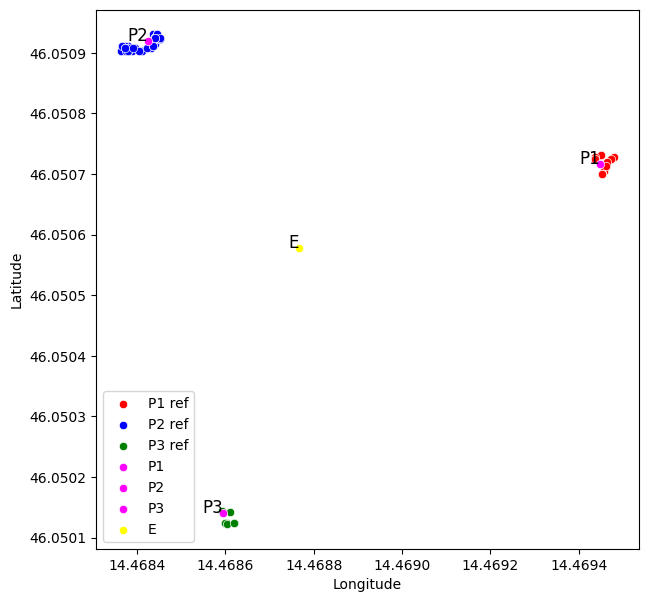

In [57]:
# TODO: modify this so it is using a projection (e.g. Mercator) for longitude and latitude to the x and y axis.
# Currently, the points are close enough to each other so it's not a big deal, but it's not correct.
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=df_p1, x="lng", y="lat", ax=ax, label="P1 ref", color="red")
sns.scatterplot(data=df_p2, x="lng", y="lat", ax=ax, label="P2 ref", color="blue")
sns.scatterplot(data=df_p3, x="lng", y="lat", ax=ax, label="P3 ref", color="green")
sns.scatterplot(x=[P1[1]], y=[P1[0]], ax=ax, label="P1", color="magenta")
sns.scatterplot(x=[P2[1]], y=[P2[0]], ax=ax, label="P2", color="magenta")
sns.scatterplot(x=[P3[1]], y=[P3[0]], ax=ax, label="P3", color="magenta")
sns.scatterplot(x=[E[1]], y=[E[0]], ax=ax, label="E", color="yellow")
ax.text(P1[1], P1[0], "P1", fontsize=12, ha='right')
ax.text(P2[1], P2[0], "P2", fontsize=12, ha='right')
ax.text(P3[1], P3[0], "P3", fontsize=12, ha='right')
ax.text(E[1], E[0], "E", fontsize=12, ha='right')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)


From here we can immediately tell, that E is more probable given the points from P1 and P1 itself. The results should reflect/quantify this.

54.93803082601422


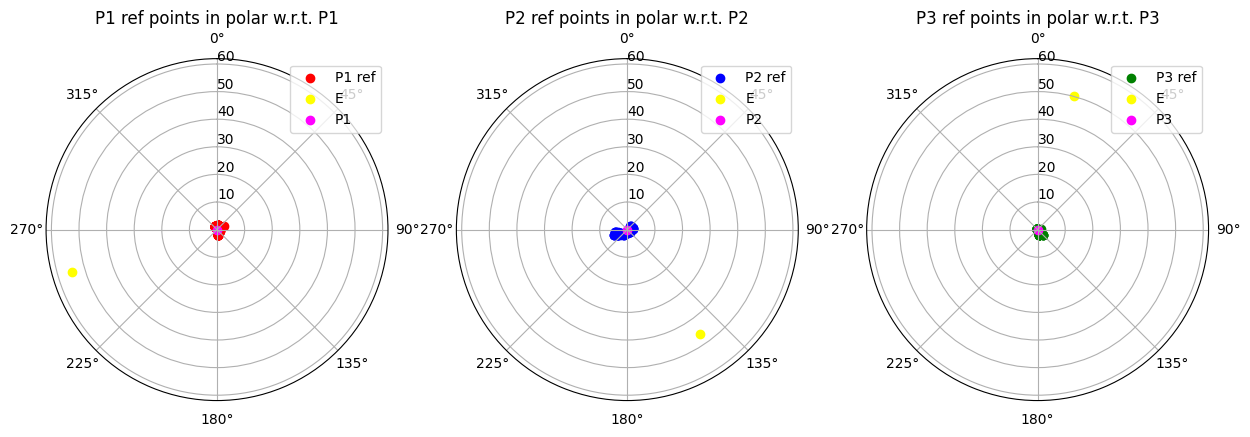

In [58]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1 in ax.flatten():
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_rlabel_position(0)

max_dist = max(max(df_p1["dist"]), max(df_p2["dist"]), max(df_p2["dist"]),E_dist_angle_wrt_P1[0],E_dist_angle_wrt_P2[0],E_dist_angle_wrt_P3[0])
print(max_dist)
max_dist+=7

    
ax[0].scatter(df_p1["angle"], df_p1["dist"], label="P1 ref", color="red")
ax[0].set_title("P1 ref points in polar w.r.t. P1")
ax[0].scatter(E_dist_angle_wrt_P1[1], E_dist_angle_wrt_P1[0], label="E", color="yellow")
ax[0].scatter(0, 0, label="P1", color="magenta")
ax[0].set_rmax(max_dist)
ax[0].legend()



ax[1].scatter(df_p2["angle"], df_p2["dist"], label="P2 ref", color="blue")
ax[1].set_title("P2 ref points in polar w.r.t. P2")
ax[1].scatter(E_dist_angle_wrt_P2[1], E_dist_angle_wrt_P2[0], label="E", color="yellow")
ax[1].scatter(0, 0, label="P2", color="magenta")
ax[1].set_rmax(max_dist)
ax[1].legend()

ax[2].scatter(df_p3["angle"], df_p3["dist"], label="P3 ref", color="green")
ax[2].set_title("P3 ref points in polar w.r.t. P3")
ax[2].scatter(E_dist_angle_wrt_P3[1], E_dist_angle_wrt_P3[0], label="E", color="yellow")
ax[2].scatter(0, 0, label="P3", color="magenta")
ax[2].set_rmax(max_dist)
ax[2].legend()
plt.show()


The polar chart seems to make sense. So P1 and P2 are computed w.r.t. the evidence point. Azimuth is measured clockwise, 0 deg being straight up. Therefore P2 is at approx. 45 degrees of azimuth w.r.t E and P1 is a bit below 360 deg azimuth.


### Bayesian approach

In [10]:
import subprocess

subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p1"])
subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p2"])
subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p3"])

This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB

* Latest CmdStan release is v2.34.1
* Installing CmdStan v2.34.1 in /home/lema

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 200

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrain

Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 2 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1700 / 2000 [ 

Warning message:
Dropping 'draws_df' class as required metadata was removed. 
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB



Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrain

Chain 1 finished in 0.2 seconds.
Chain 2 finished in 0.2 seconds.
Chain 3 finished in 0.3 seconds.
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 0.4 seconds.

# A tibble: 7 × 10
  variable       mean   median    sd   mad       q5      q95  rhat ess_bulk
  <chr>         <dbl>    <dbl> <dbl> <dbl>    <dbl>    <dbl> <dbl>    <dbl>
1 lp__       -134.    -133.    1.54  1.40  -137.    -132.     1.00    2185.
2 mu[1]         1.74     1.74  0.105 0.102    1.57     1.92   1.00    4106.
3 mu[2]         3.25     3.25  0.165 0.169    2.98     3.52   1.00    4336.
4 sigma[1,1]    1.06     1.05  0.161 0.157    0.822    1.34   1.00    4580.
5 sigma[2,1]   -0.454   -0.447 0.184 0.176   -0.774   -0.173  1.00    3821.
6 sigma[1,2]   -0.454   -0.447 0.184 0.176   -0.774   -0.173  1.00    3821.
7 sigma[2,2]    2.66     2.62  0.390 0.383    2.09     3.35   1.00    4698.
# ℹ 1 more variable: ess_tail <dbl>


Warning message:
Dropping 'draws_df' class as required metadata was removed. 
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB



Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 200

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 2 Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 2 If this warning occurs sporadically, such as for highly

Chain 1 finished in 0.3 seconds.
Chain 2 finished in 0.3 seconds.
Chain 3 finished in 0.3 seconds.
Chain 4 finished in 0.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.3 seconds.
Total execution time: 0.4 seconds.

# A tibble: 7 × 10
  variable      mean  median    sd   mad      q5     q95  rhat ess_bulk ess_tail
  <chr>        <dbl>   <dbl> <dbl> <dbl>   <dbl>   <dbl> <dbl>    <dbl>    <dbl>
1 lp__       -177.   -177.   1.62  1.49  -180.   -175.    1.00    1939.    2221.
2 mu[1]        10.6    10.6  0.226 0.221   10.3    11.0   1.00    3058.    2967.
3 mu[2]         3.16    3.16 0.169 0.164    2.88    3.44  1.00    3083.    2899.
4 sigma[1,1]    4.78    4.72 0.715 0.672    3.73    6.03  1.00    3300.    2935.
5 sigma[2,1]    2.34    2.30 0.436 0.427    1.69    3.11  1.00    3087.    2921.
6 sigma[1,2]    2.34    2.30 0.436 0.427    1.69    3.11  1.00    3087.    2921.
7 sigma[2,2]    2.60    2.56 0.389 0.385    2.04    3.31  1.00    3766.    2991.


Warning message:
Dropping 'draws_df' class as required metadata was removed. 


0

In [21]:
# folder = "original/"
# TODO ploti posebej

In [10]:
# Read the MCMC draws (each row, is a parametrization of a bivariate normal distribution)
p1_draws_df = pd.read_csv(folder+'p1_draws.csv')
p2_draws_df = pd.read_csv(folder+'p2_draws.csv')
p3_draws_df = pd.read_csv(folder+'p3_draws.csv')

# Reshape the data to mean vector and covariance matrix for each draw
p1_mean = p1_draws_df[['mu_dist', 'mu_angle']].values
p1_covariance = p1_draws_df[['sigma11', 'sigma12', 'sigma21', 'sigma22']].values.reshape(-1, 2, 2)
p2_mean = p2_draws_df[['mu_dist', 'mu_angle']].values
p2_covariance = p2_draws_df[['sigma11', 'sigma12', 'sigma21', 'sigma22']].values.reshape(-1, 2, 2)
p3_mean = p3_draws_df[['mu_dist', 'mu_angle']].values
p3_covariance = p3_draws_df[['sigma11', 'sigma12', 'sigma21', 'sigma22']].values.reshape(-1, 2, 2)

In [39]:
# np.isnan(p1_mean).any()
# np.isnan(p2_mean).any()
# np.isnan(p3_mean).any()
# np.isnan(p1_covariance).any()
# np.isnan(p2_covariance).any()
# np.isnan(p3_covariance).any()

False

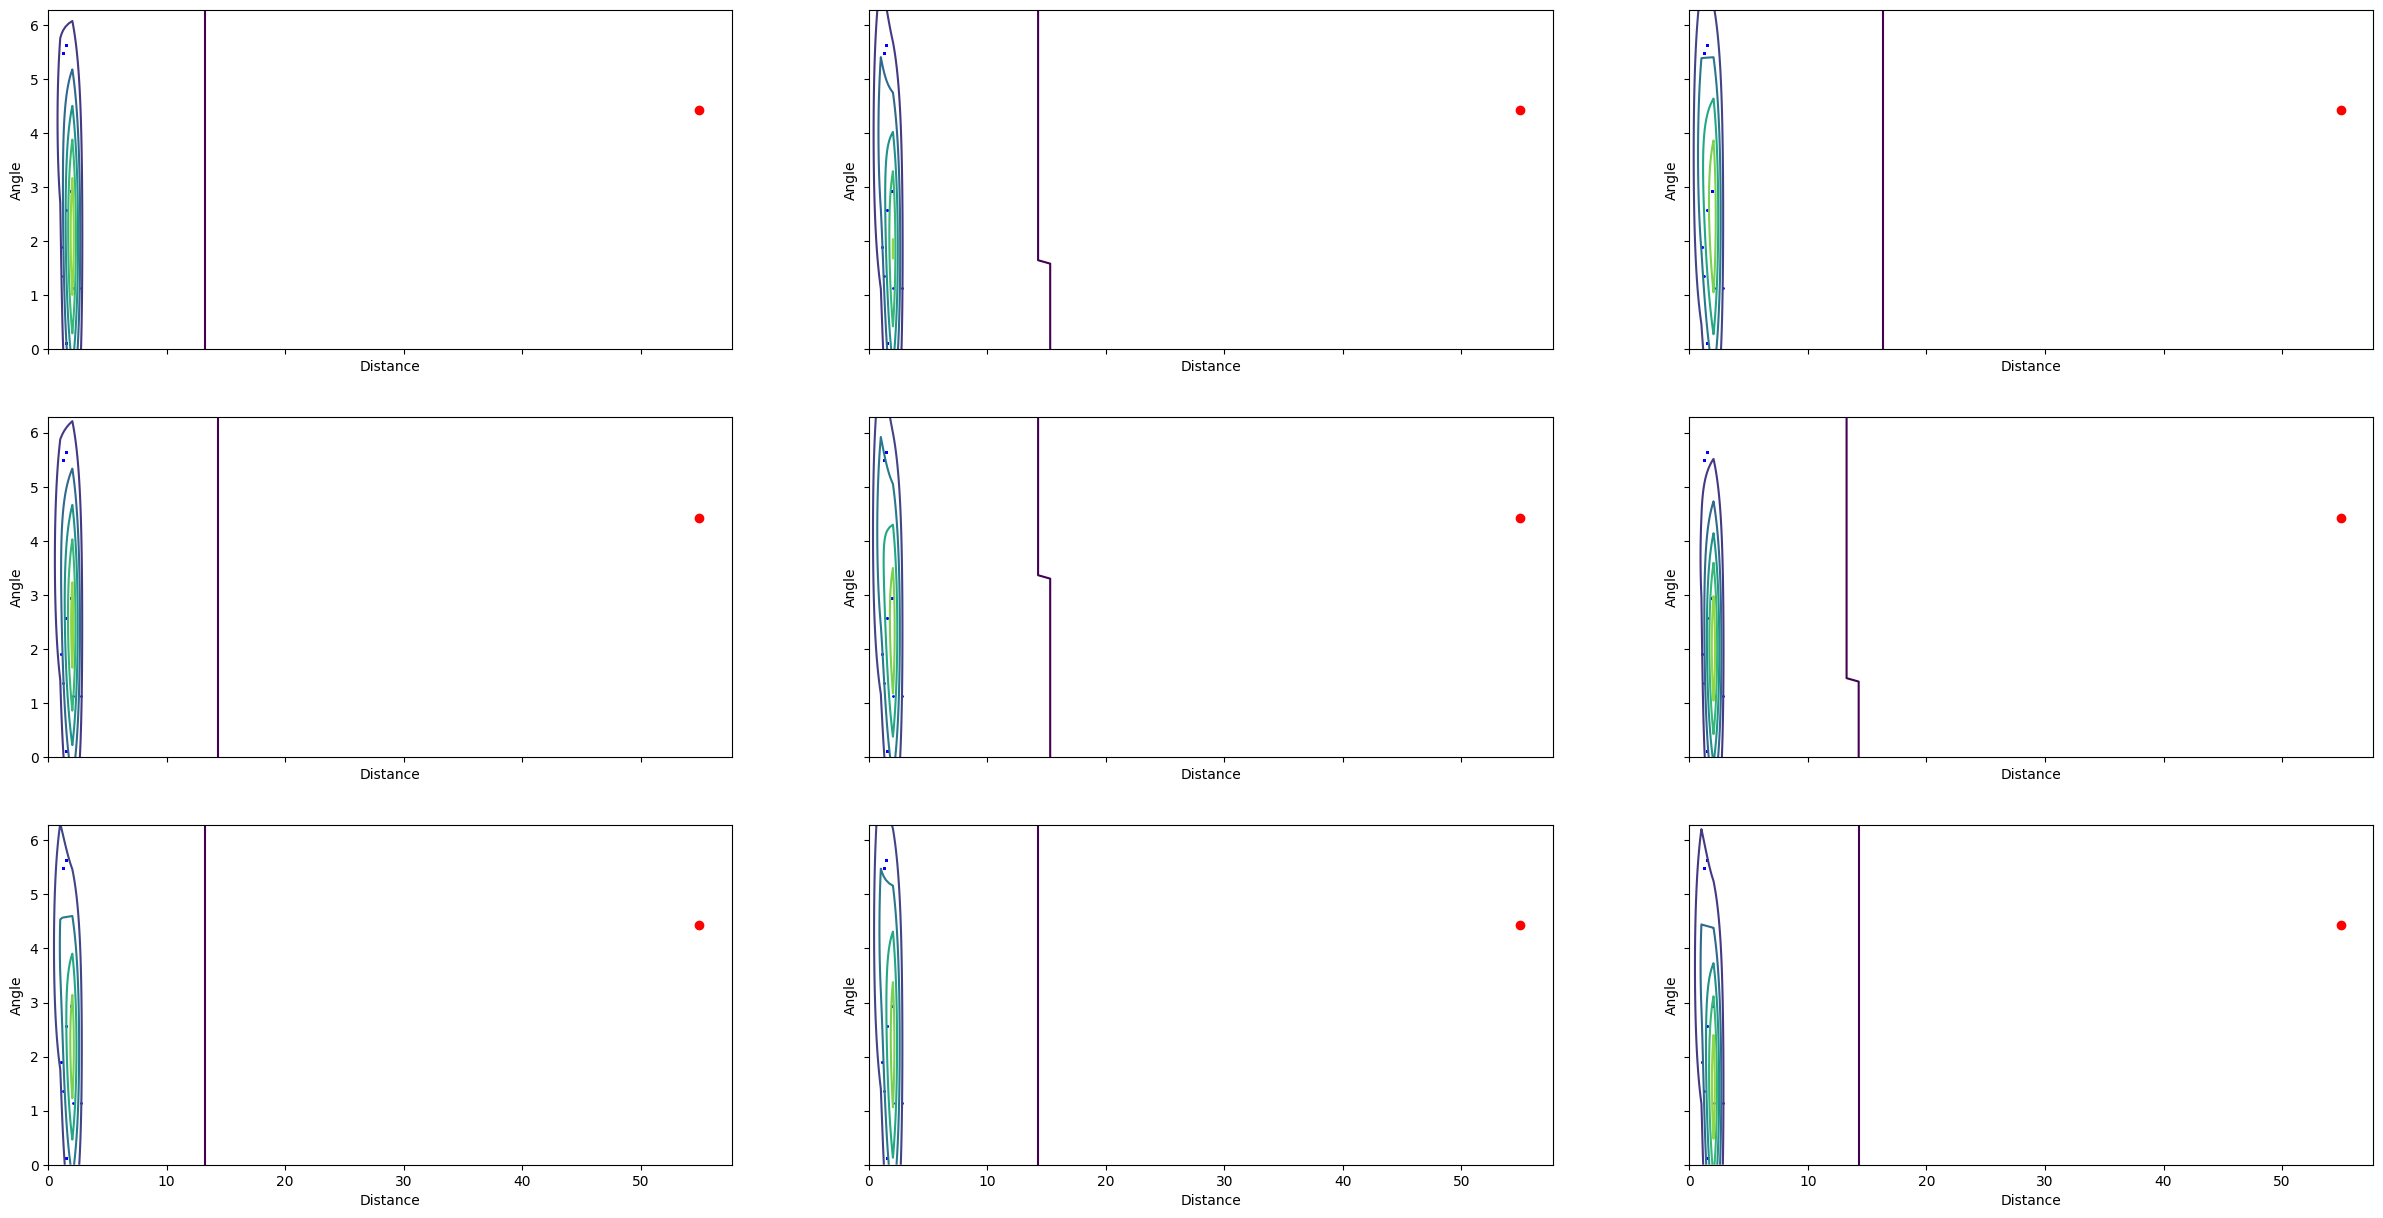

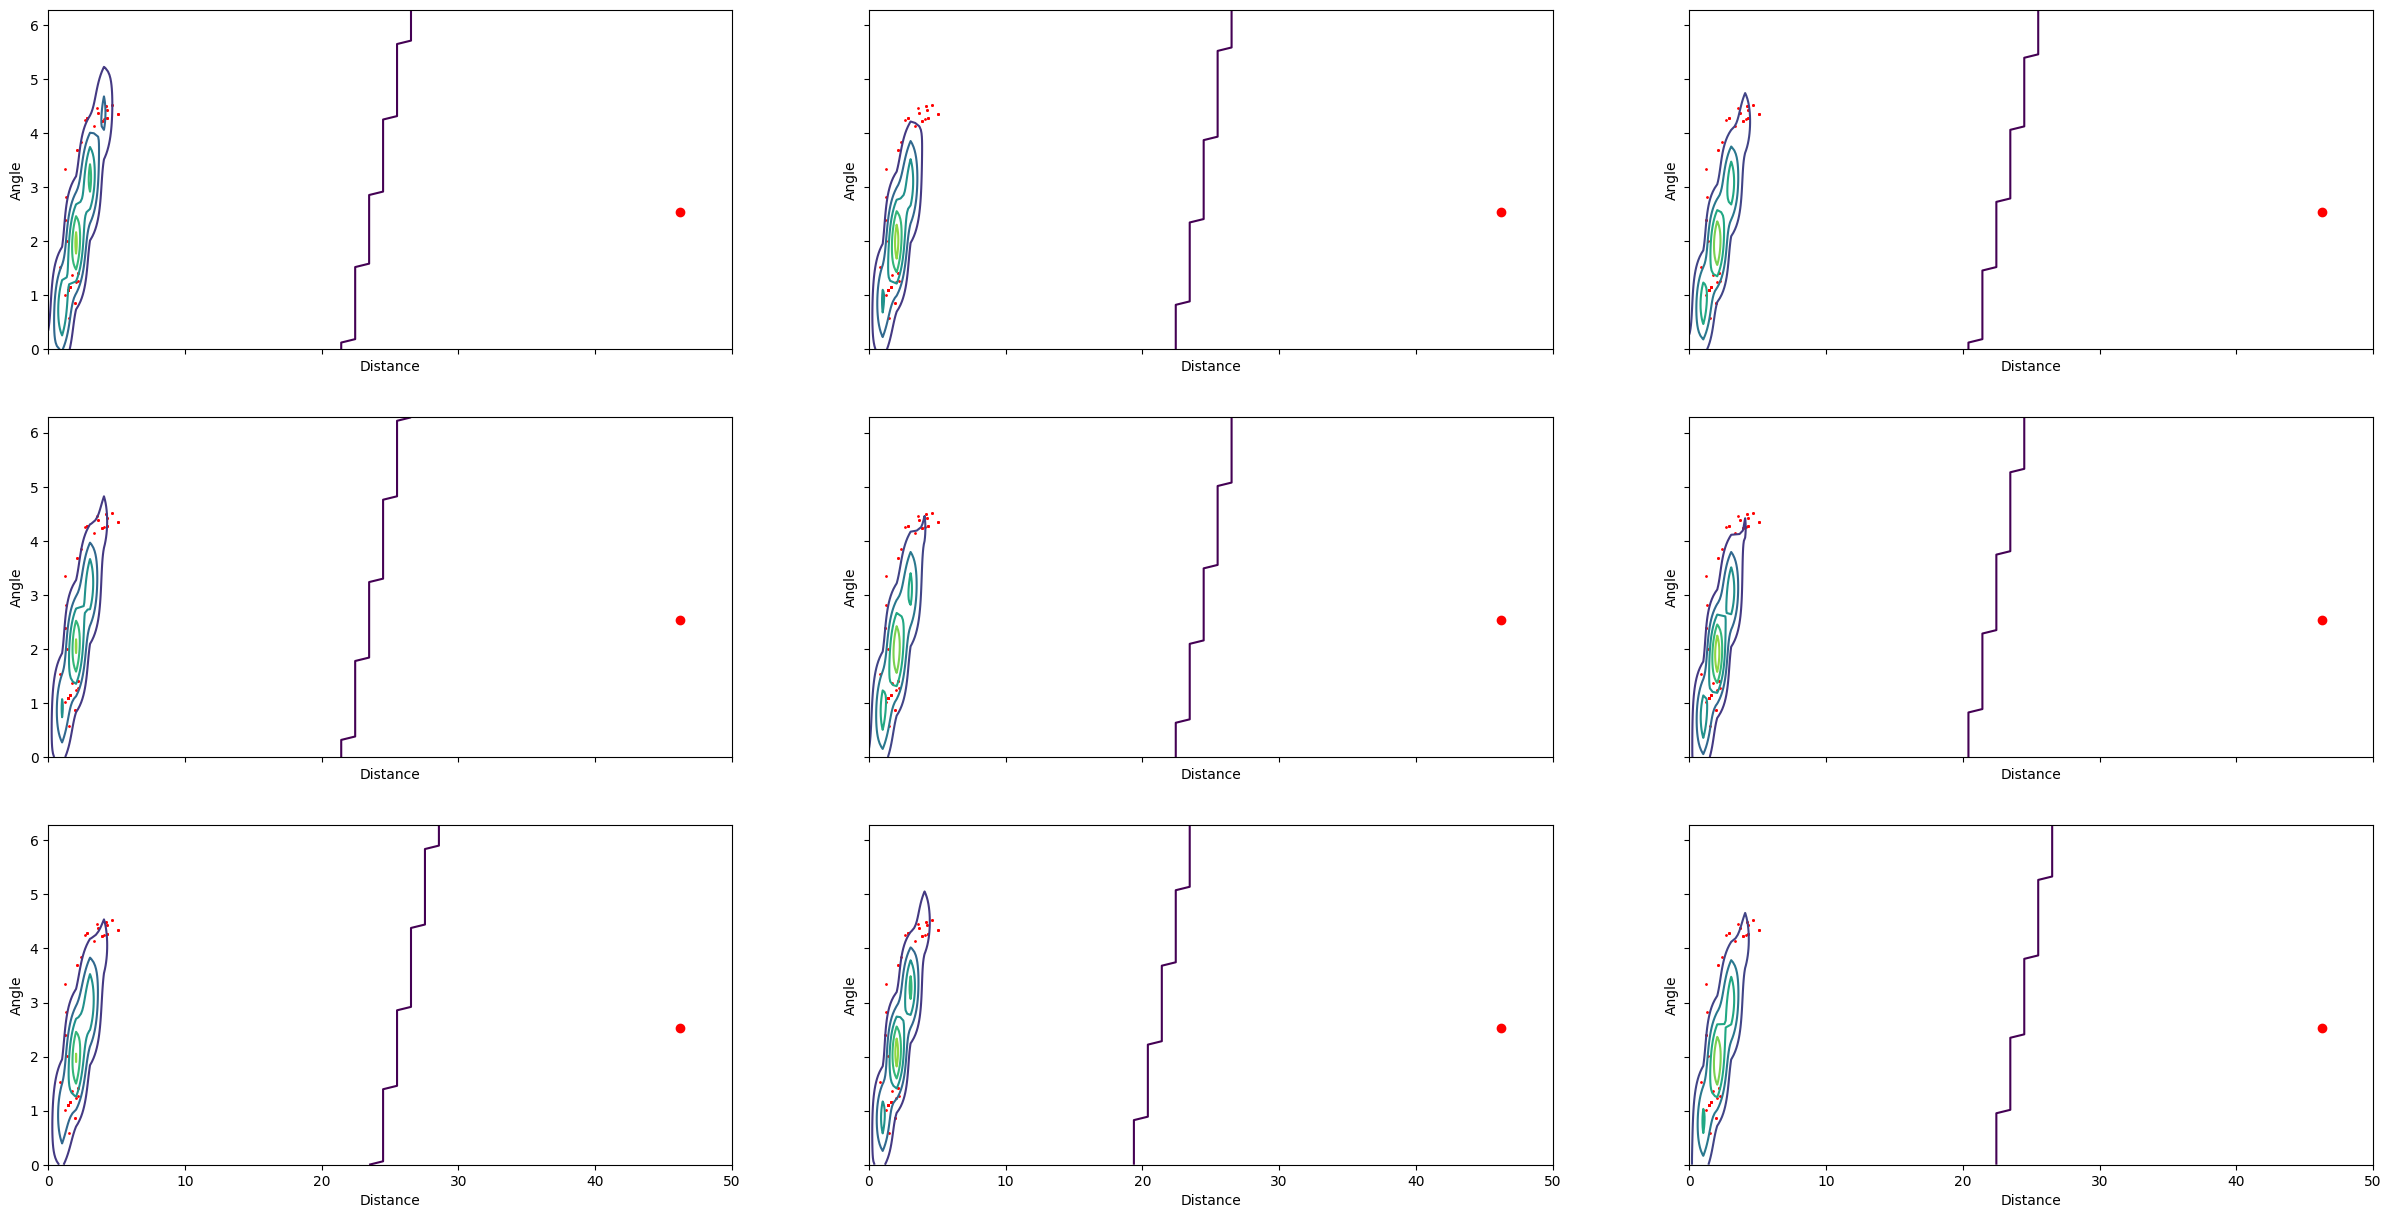

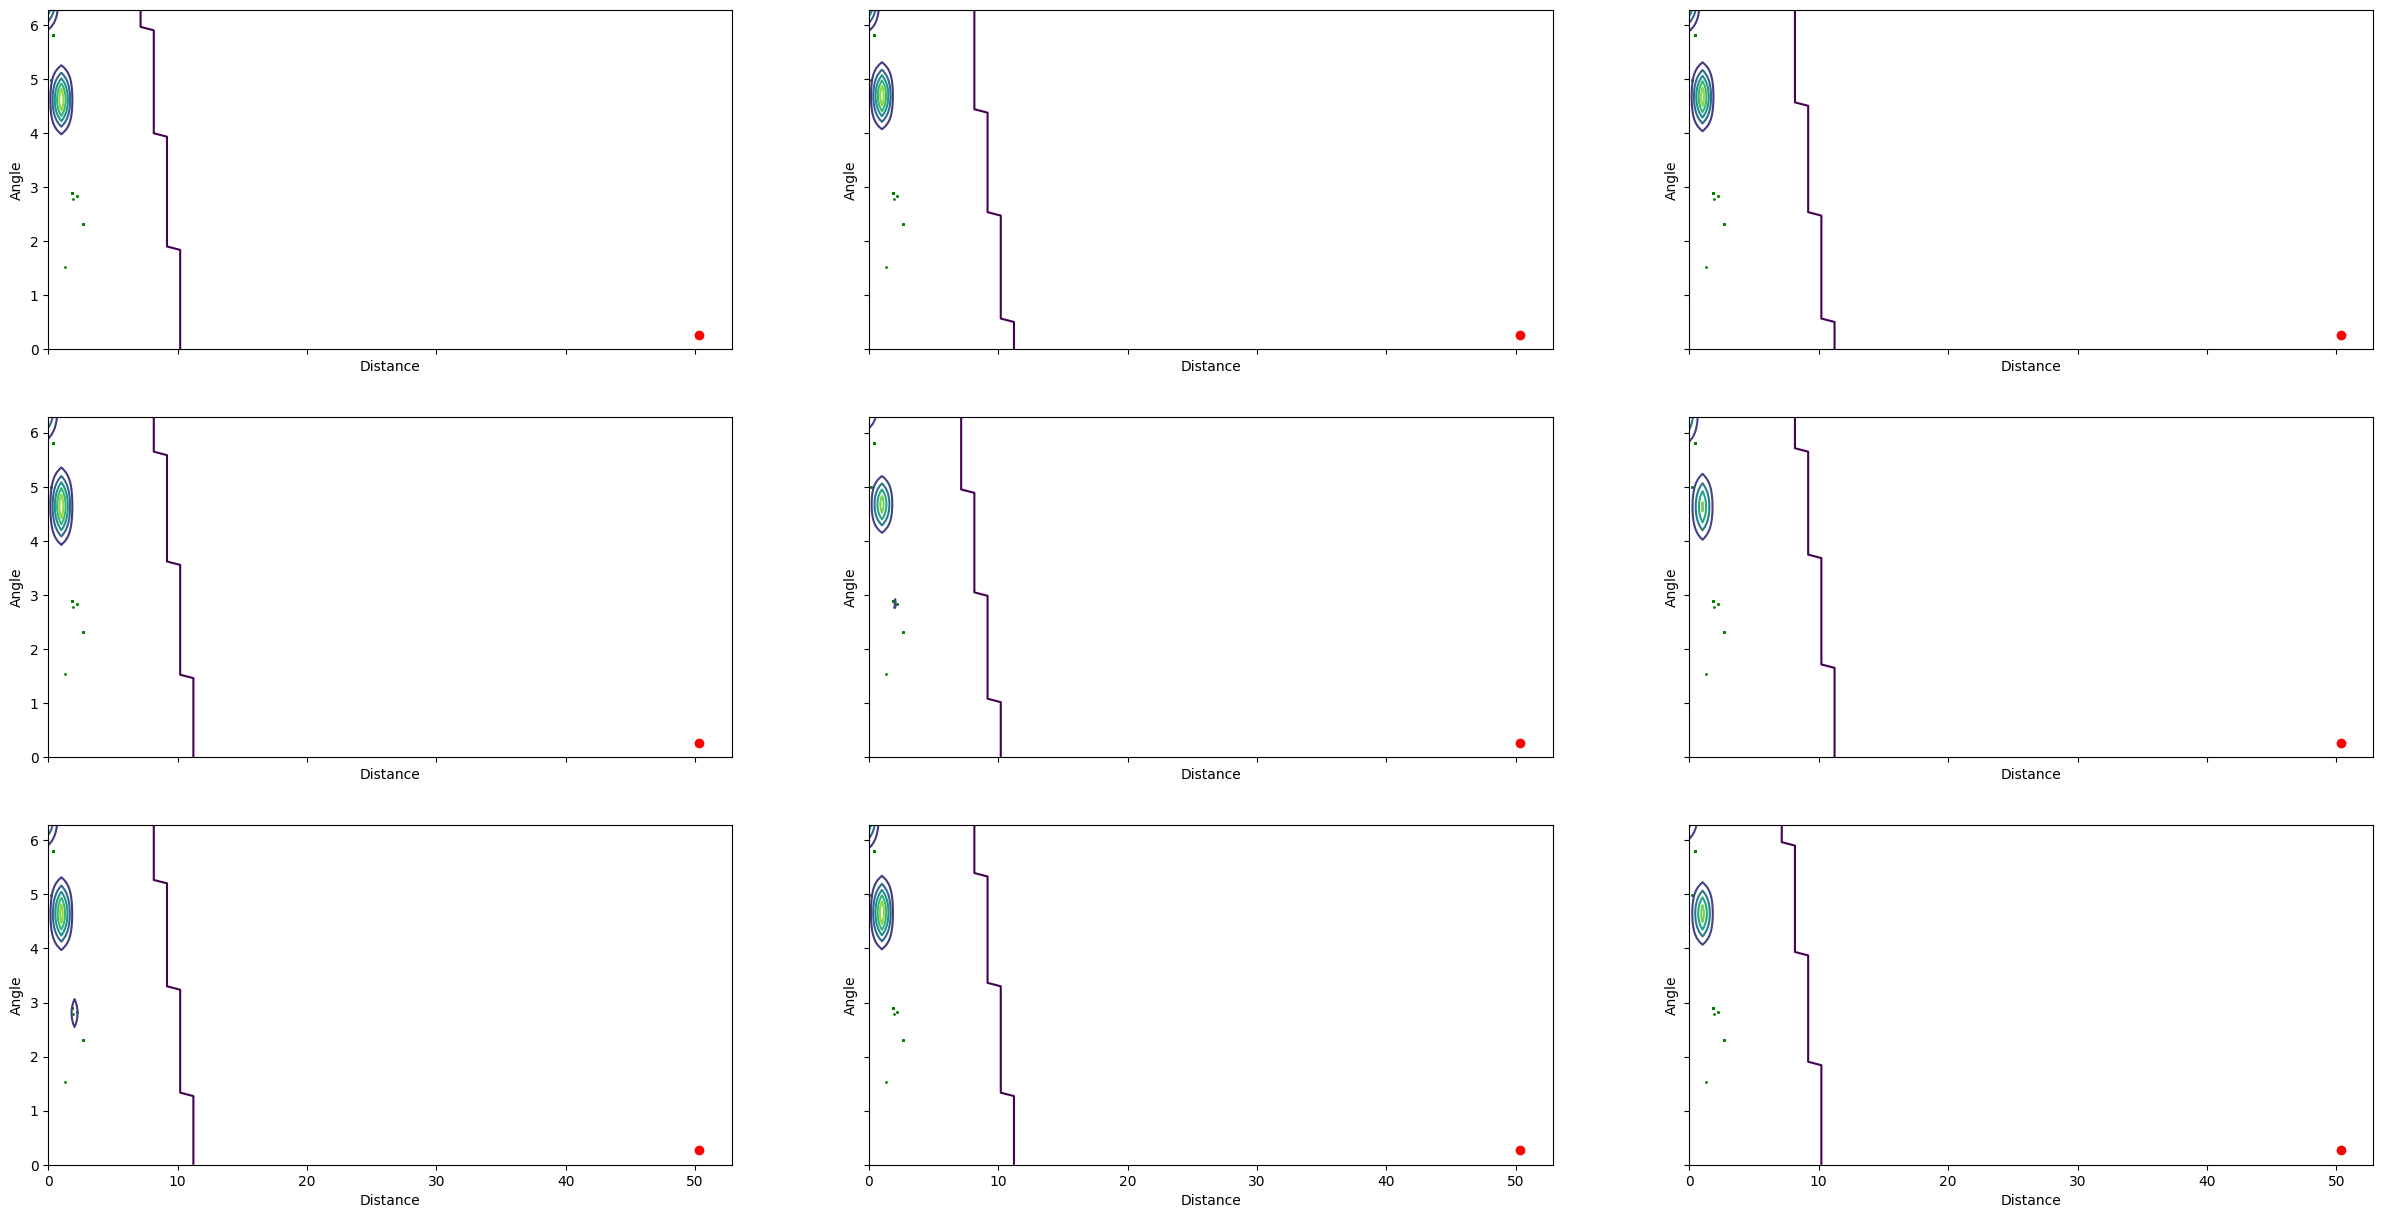

In [59]:
# Create a grid of points for plotting the contours
MAX_DISTANCE = 50
for p in ["p1","p2","p3"]:
    distance = np.linspace(0, MAX_DISTANCE, MAX_DISTANCE)
    angle = np.linspace(0, 2* math.pi, 100)
    X, Y = np.meshgrid(distance, angle)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # Sample points from the multivariate normal parametrized by the draws
    zs = []
    # Plot 9 random fitted bivariate normal distributions
    fig, ax = plt.subplots(3,3, figsize=(30, 15), sharex=True, sharey=True)
    for ax1 in ax.flatten():
        i = np.random.choice(range(len(p1_mean)))
        
        
        
        ax1.set_xlabel('Distance')
        ax1.set_ylabel('Angle')

        # Plot the points
        if p == "p1":
            ax1.scatter(df_p1['dist'], df_p1['angle'], c='b', label='P1 ref', s=1)
            ax1.scatter(E_dist_angle_wrt_P1[0], E_dist_angle_wrt_P1[1], c='r', label='P1')
            Z = stats.multivariate_normal.pdf(pos, mean=p1_mean[i], cov=p1_covariance[i])
            ax1.contour(X, Y, Z, 5)
        elif p == "p2":
            ax1.scatter(df_p2['dist'], df_p2['angle'], c='r', label='P2 ref', s=1)
            ax1.scatter(E_dist_angle_wrt_P2[0], E_dist_angle_wrt_P2[1], c='r', label='P2')
            Z = stats.multivariate_normal.pdf(pos, mean=p2_mean[i], cov=p2_covariance[i])
            ax1.contour(X, Y, Z, 5)
        elif p == "p3":
            ax1.scatter(df_p3['dist'], df_p3['angle'], c='g', label='P3 ref', s=1)
            ax1.scatter(E_dist_angle_wrt_P3[0], E_dist_angle_wrt_P3[1], c='r', label='P3')
            Z = stats.multivariate_normal.pdf(pos, mean=p3_mean[i], cov=p3_covariance[i])
            ax1.contour(X, Y, Z, 5)
    plt.show()


In [60]:
# Evaluate each sampled bivariate normal distribution at the point E (with respect to P1 and P2)
# This results in a bunch of probabilities P(E|P1) and P(E|P2)
e_given_p1_probs = []
e_given_p2_probs = []
e_given_p3_probs = []

for i in range(len(p1_mean)):
    e_given_p1_probs.append(stats.multivariate_normal.pdf(E_dist_angle_wrt_P1, mean=p1_mean[i], cov=p1_covariance[i]))
    e_given_p2_probs.append(stats.multivariate_normal.pdf(E_dist_angle_wrt_P2, mean=p2_mean[i], cov=p2_covariance[i]))
    e_given_p3_probs.append(stats.multivariate_normal.pdf(E_dist_angle_wrt_P3, mean=p3_mean[i], cov=p3_covariance[i]))

e_given_p1_probs = np.array(e_given_p1_probs)
e_given_p2_probs = np.array(e_given_p2_probs)
e_given_p3_probs = np.array(e_given_p3_probs)


print(f"Probability of E given P1: {e_given_p1_probs.mean()} +/- {e_given_p1_probs.std()}")
print(f"Probability of E given P2: {e_given_p2_probs.mean()} +/- {e_given_p2_probs.std()}")
print(f"Probability of E given P3: {e_given_p3_probs.mean()} +/- {e_given_p3_probs.std()}")

def compute_lrs(p1, e_given_p1_probs, p2, e_given_p2_probs,limit = 50):
    # Compute likelihood ratios from the probabilitiess
    lrs = (e_given_p1_probs / e_given_p2_probs)
    hdi_min, hdi_max = az.hdi(lrs, hdi_prob=0.95)
    # Show summary statistics
    # min and max LR
    print(f"LR: {round(lrs.mean()):,} +/- {round(lrs.std()):,}")
    print(f"min LR: {round(lrs.min()):,}, max LR: {round(lrs.max()):,}")
    print(f"95% HDI of LR: [{round(hdi_min):,}, {round(hdi_max):,}]")
    


    try:
        lrs = lrs[:limit]
        # Plot a histogram of likelihood ratios
        fig, ax = plt.subplots(1, 2, figsize=(15,7))
        # two histograms ,one with log x one without
        sns.histplot(lrs, kde=True, ax=ax[0])
        sns.histplot(lrs, kde=True, ax=ax[1], log_scale=(True, False))
        ax[0].set_xlabel(f"Likelihood ratio: P(E|{p1})/P(E|{p2}) (linear x scale)")
        ax[0].set_ylabel("Density")
        ax[1].set_xlabel(f"Likelihood ratio: P(E|{p1})/P(E|{p2}) (log x scale)")
        ax[1].set_ylabel("Density")

        ax[0].axvline(lrs.mean(), color='r', linestyle='--', label='mean')
        ax[0].axvline(np.median(lrs), color='g', linestyle='--', label='median')
        ax[0].axvline(hdi_min, color='b', linestyle='--', label='95% HDI')
        ax[0].axvline(hdi_max, color='b', linestyle='--')
        ax[0].legend()

        ax[1].axvline(lrs.mean(), color='r', linestyle='--', label='mean')
        ax[1].axvline(np.median(lrs), color='g', linestyle='--', label='median')
        ax[1].axvline(hdi_min, color='b', linestyle='--', label='95% HDI')
        ax[1].axvline(hdi_max, color='b', linestyle='--')
        ax[1].legend()
    except MemoryError:
        print("MemoryError")
    
print("p1, p2:")
compute_lrs("P1", e_given_p1_probs, "P2", e_given_p2_probs)

print("p2, p3:")
compute_lrs("P2", e_given_p2_probs, "P3", e_given_p3_probs)

Probability of E given P1: 0.0 +/- 0.0
Probability of E given P2: 0.0 +/- 0.0
Probability of E given P3: 0.0 +/- 0.0
p1, p2:


/tmp/ipykernel_43312/3293335615.py:23: RuntimeWarning: invalid value encountered in divide
  lrs = (e_given_p1_probs / e_given_p2_probs)


ValueError: cannot convert float NaN to integer

We can see that the LR distribution is extremely long tailed. Which the original authors also mentioned in the paper - the method is unstable since P(E|P1) is much more probable than P(E|P2).

Our approach improves the original one by:
- Estimating both probabilities directly using MCMC, this means:
  - We don't have to choose the angular wedge size at all, since we don't even have a wedge - the original authors said that there is no obvious way of choosing it.
  - Since we are using MCMC, we fit a bunch of distributions to the data, allowing us to quantify the uncertainty in LR using standard deviation (discussed below) and a 95% high-density interval and therefore at give a measure of how (un)stable the model is. This allows us to interpret the results including the uncertainty (see [page 39 here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/960051/FSR-C-118_Interpretation_Appendix_Issue_1__002_.pdf) and Table 4 in the original paper).
- We noticed the error in long/lat mixups.

As seen from the histogram, due to the heavy skew, a standard deviation from the mean is not a good explanation of the uncertainty, this is why we include 95% HDI.


### Map visualization

In [61]:
import folium
lat, lon = E

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=20, zoom_control=False, scrollWheelZoom=False,
               dragging=False)

for df in [df_p1,df_p2,df_p3]:
    for point in list(zip(df["lat"], df["lng"])):
        folium.CircleMarker(
            location=point,
            color = "blue",
            opacity=0.5,
            radius=2
            
        ).add_to(m)

for name, point in {"E":E,"P1":P1,"P2":P2,"P3":P3}.items():
    folium.CircleMarker(
        location=point,
        popup=name,
        color = "red",
        radius = 2
        
    ).add_to(m)


    
m